Agent episode lengths

So for: | ep_len_mean      | 3.6e+03  |  ← 3600 steps/episode


Expert → 150k / 3000 = ~50 episodes

Intermediate → 150k / 2000 = ~75 episodes

Beginner → 150k / 500 = ~300 episodes

You can estimate once and set fixed values for reproducibility.

# Generate Datasets

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

In [2]:
SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'

In [3]:
# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, check_dataset, save_dataset, load_dataset, preprocess_and_split, create_dataloaders, inspect_dataset_sample, analyze_action_distribution, generate_dataset_until_n

import auxiliary_methods.utils
importlib.reload(auxiliary_methods.utils)

from auxiliary_methods.utils import load_iql_return_stats

In [5]:
# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [6]:
# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

# AGENT

In [6]:
# Define the DQN hyperparameters
dqn_params = {
    'learning_rate': 0.0001,
    'buffer_size': 10000,
    'learning_starts': 100000,
    'batch_size': 32,
    'train_freq': 4,
    'gradient_steps': 1,
    'target_update_interval': 1000,
    'exploration_fraction': 0.1,
    'exploration_initial_eps': 1.0,
    'exploration_final_eps': 0.01,
    'device': device,
    'seed': SEED,
    'verbose': 1,
}

# Initialize the DQN agent
dqn_agent = DQN('CnnPolicy', env, **dqn_params)

# Train the agent
dqn_agent.learn(total_timesteps=1_000_000)

# Save the trained model
dqn_agent.save("dqn_seaquest_expert_agent(1mio)")

# took 416min 42s to train (5MIO timesteps)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.76e+03 |
|    ep_rew_mean      | 90       |
|    exploration_rate | 0.891    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2557     |
|    time_elapsed     | 4        |
|    total_timesteps  | 11045    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | 95       |
|    exploration_rate | 0.769    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3356     |
|    time_elapsed     | 6        |
|    total_timesteps  | 23297    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 

continue training the agent

In [ ]:
# Re-create the environment
env = create_environment(env_id=ENV_ID, seed=SEED)

# Load the saved model
dqn_agent = DQN.load("dqn_seaquest_expert_agent(5mio)", env=env, device=device)

# Continue training the agent
additional_timesteps = 5_000_000 # Train for an additional 5 million timesteps
dqn_agent.learn(total_timesteps=additional_timesteps)

# Save the updated model
dqn_agent.save("dqn_seaquest_expert_agent(10mio)")

# took 375min 15s to train

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.76e+03 |
|    ep_rew_mean      | 90       |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4236     |
|    time_elapsed     | 2        |
|    total_timesteps  | 11045    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | 95       |
|    exploration_rate | 0.954    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4448     |
|    time_elapsed     | 5        |
|    total_timesteps  | 23297    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.85e+03 |
|    ep

In [ ]:
def evaluate_dqn_agent(env, model, num_episodes=10):
    episode_rewards = []
    action_counts = {}
    # use tqdm
    for episode in tqdm(range(num_episodes)):
        obs, info = env.reset()
        done = False
        total_rewards = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)

            # Convert action to scalar if it's a NumPy array
            if isinstance(action, np.ndarray):
                action = action.item()
                
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_rewards += reward
            # Log action
            action_counts[action] = action_counts.get(action, 0) + 1
            
        episode_rewards.append(total_rewards)
        print(f"Episode {episode + 1}: Total Reward = {total_rewards}")
    average_reward = np.mean(episode_rewards)
    print(f"Average Reward over {num_episodes} episodes: {average_reward}")
    print(f"Action Counts: {action_counts}")
    return average_reward, action_counts

# Evaluate the trained DQN agent
average_reward, action_counts = evaluate_dqn_agent(env, DQN.load("dqn_seaquest_expert_agent(5Mio)", device=device, env=env))

 10%|█         | 1/10 [00:09<01:24,  9.33s/it]

Episode 1: Total Reward = 660.0


 20%|██        | 2/10 [00:15<00:57,  7.21s/it]

Episode 2: Total Reward = 660.0


 30%|███       | 3/10 [00:20<00:46,  6.59s/it]

Episode 3: Total Reward = 660.0


 40%|████      | 4/10 [00:27<00:38,  6.40s/it]

Episode 4: Total Reward = 660.0


 50%|█████     | 5/10 [00:32<00:31,  6.24s/it]

Episode 5: Total Reward = 660.0


 60%|██████    | 6/10 [00:38<00:24,  6.14s/it]

Episode 6: Total Reward = 660.0


 70%|███████   | 7/10 [00:44<00:18,  6.07s/it]

Episode 7: Total Reward = 660.0


 80%|████████  | 8/10 [00:50<00:12,  6.03s/it]

Episode 8: Total Reward = 660.0


 90%|█████████ | 9/10 [00:56<00:05,  5.99s/it]

Episode 9: Total Reward = 660.0


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]

Episode 10: Total Reward = 660.0
Average Reward over 10 episodes: 660.0
Action Counts: {16: 2317, 7: 1290, 9: 3460, 12: 2100, 15: 5400, 6: 3180, 14: 680, 17: 1000, 8: 4370, 13: 3610, 2: 830, 0: 1990, 10: 1010, 1: 2070, 11: 700, 3: 5550, 5: 210, 4: 1610}


## beginner dataset (1 Million Agent)

In [ ]:
# load the agent (self trained agent, for 1M steps)
beginner_agent = DQN.load("dqn_seaquest_beginner_agent(1Mio)", device=device, env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


### 0%

In [ ]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

file_name = 'seaquest_beginner_perturb0.pkl'

In [ ]:
# generate dataset with 150k transitions from beginner agent, 0% perturbed
seaquest_beginner_perturb0 = generate_dataset_until_n(
    env=env,
    model=beginner_agent,
    target_size=150_000,
    perturbation=False,
    perturbation_level=0.0,
    save_path='datasets/beginner_logs',
    file_name=file_name,
    plotting=False,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 0
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb0.pkl


Check Dataset Action Distribution

In [9]:
# Analyze the dataset
action_distribution = analyze_action_distribution(seaquest_beginner_perturb0)

Action distribution in expert dataset: {0: 10600, 1: 1560, 2: 369, 3: 1919, 4: 11929, 5: 16187, 6: 13218, 7: 1666, 8: 17239, 9: 1572, 10: 31397, 11: 3104, 12: 3743, 13: 20456, 14: 3757, 15: 4852, 16: 1338, 17: 5094}


plotting Dataset (with additional information)

In [8]:
# generate dataset with 150k transitions from beginner agent, 0% perturbed
seaquest_beginner_perturb0_plot = generate_dataset_until_n(
    env=env,
    model=beginner_agent,
    target_size=150_000,
    perturbation=False,
    perturbation_level=0.0,
    save_path='datasets/beginner_logs',
    file_name=file_name,
    plotting=True,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 0
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb0_plotting.pkl


In [ ]:
# free up memory
del seaquest_beginner_perturb0, seaquest_beginner_perturb0_plot, action_distribution

### 5%

In [7]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

file_name = 'seaquest_beginner_perturb5.pkl'

In [8]:
# generate dataset with 150k transitions from beginner agent, 5% perturbed
seaquest_beginner_perturb5 = generate_dataset_until_n(
    env=env,
    model=beginner_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.05,
    save_path='datasets/beginner_logs',
    file_name=file_name,
    plotting=False,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 7652
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb5.pkl


Check Dataset Action Distribution

In [10]:
# Analyze the dataset
action_distribution = analyze_action_distribution(seaquest_beginner_perturb5)

Action distribution in expert dataset: {0: 9207, 1: 1564, 2: 913, 3: 2926, 4: 11160, 5: 16587, 6: 13804, 7: 2258, 8: 20739, 9: 2136, 10: 25133, 11: 3474, 12: 5693, 13: 16028, 14: 4610, 15: 6732, 16: 1972, 17: 5064}


plotting Dataset (with additional information)

In [8]:
# generate dataset with 150k transitions from beginner agent, 5% perturbed
seaquest_beginner_perturb5_plot = generate_dataset_until_n(
    env=env,
    model=beginner_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.05,
    save_path='datasets/beginner_logs',
    file_name=file_name,
    plotting=True,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 7652
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb5_plotting.pkl


In [ ]:
# free up memory
del seaquest_beginner_perturb5, seaquest_beginner_perturb5_plot, action_distribution

### 10%

In [7]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

file_name = 'seaquest_beginner_perturb10.pkl'

In [8]:
# generate dataset with 150k transitions from beginner agent, 10% perturbed
seaquest_beginner_perturb10 = generate_dataset_until_n(
    env=env,
    model=beginner_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.1,
    save_path='datasets/beginner_logs',
    file_name=file_name,
    plotting=False,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 15281
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb10.pkl


Check Dataset Action Distribution

In [9]:
# Analyze the dataset
action_distribution = analyze_action_distribution(seaquest_beginner_perturb10)

Action distribution in expert dataset: {0: 9175, 1: 1914, 2: 1400, 3: 2862, 4: 10700, 5: 16382, 6: 13687, 7: 2736, 8: 21217, 9: 2602, 10: 22532, 11: 3614, 12: 6666, 13: 13720, 14: 5308, 15: 7917, 16: 2371, 17: 5197}


plotting dataset (with additional information)

In [8]:
# generate dataset with 150k transitions from beginner agent, 10% perturbed
seaquest_beginner_perturb10_plot = generate_dataset_until_n(
    env=env,
    model=beginner_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.1,
    save_path='datasets/beginner_logs',
    file_name=file_name,
    plotting=True,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 15281
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb10_plotting.pkl


In [ ]:
# free up memory
del seaquest_beginner_perturb10, seaquest_beginner_perturb10_plot, action_distribution

### 20%

In [7]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

file_name = 'seaquest_beginner_perturb20.pkl'

In [ ]:
# generate dataset with 150k transitions from beginner agent, 20% perturbed
seaquest_beginner_perturb20 = generate_dataset_until_n(
    env=env,
    model=beginner_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.2,
    save_path='datasets/beginner_logs',
    file_name=file_name,
    plotting=False,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 30152
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb20.pkl


Check Dataset Action Distribution

In [9]:
# Analyze the dataset
action_distribution = analyze_action_distribution(seaquest_beginner_perturb20)

Action distribution in expert dataset: {0: 8849, 1: 2469, 2: 2261, 3: 3508, 4: 9726, 5: 15246, 6: 13259, 7: 3470, 8: 19585, 9: 3365, 10: 21203, 11: 3837, 12: 6967, 13: 13032, 14: 6294, 15: 7714, 16: 3169, 17: 6046}


plotting Dataset (with additional information)

In [ ]:
# generate dataset with 150k transitions from beginner agent, 20% perturbed
seaquest_beginner_perturb20_plot = generate_dataset_until_n(
    env=env,
    model=beginner_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.2,
    save_path='datasets/beginner_logs',
    file_name=file_name,
    plotting=True,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 30152
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb20_plotting.pkl


In [ ]:
# free up memory
del seaquest_beginner_perturb20, seaquest_beginner_perturb20_plot, action_distribution

## intermediate dataset (5 Million Agent)

In [6]:
# load the agent (self trained agent, for 5M steps)
intermediate_agent = DQN.load("dqn_seaquest_intermediate_agent(5Mio)", device=device, env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


### 0%

In [8]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

file_name = 'seaquest_intermediate_perturb0.pkl'

In [8]:
# generate dataset with 150k transitions from intermediate agent, 0% perturbed
seaquest_intermediate_perturb0 = generate_dataset_until_n(
    env=env,
    model=intermediate_agent,
    target_size=150_000,
    perturbation=False,
    perturbation_level=0.0,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
    plotting=False,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 0
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb0.pkl


Check Dataset Action Distribution

In [10]:
# Analyze the dataset
action_distribution = analyze_action_distribution(seaquest_intermediate_perturb0)

Action distribution in expert dataset: {0: 7227, 1: 7545, 2: 3042, 3: 19992, 4: 5818, 5: 758, 6: 11510, 7: 4704, 8: 15841, 9: 12584, 10: 3670, 11: 2555, 12: 7581, 13: 13073, 14: 2452, 15: 19560, 16: 8466, 17: 3622}


plotting Dataset (with additional information)

In [9]:
# generate dataset with 150k transitions from intermediate agent, 0% perturbed
seaquest_intermediate_perturb0_plot = generate_dataset_until_n(
    env=env,
    model=intermediate_agent,
    target_size=150_000,
    perturbation=False,
    perturbation_level=0.0,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
    plotting=True,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 0
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb0_plotting.pkl


In [ ]:
# free up memory
del seaquest_intermediate_perturb0, seaquest_intermediate_perturb0_plot, action_distribution

### 5%

In [7]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

file_name = 'seaquest_intermediate_perturb5.pkl'

In [8]:
# generate dataset with 150k transitions from intermediate agent, 5% perturbed
seaquest_intermediate_perturb5 = generate_dataset_until_n(
    env=env,
    model=intermediate_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.05,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
    plotting=False,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 7652
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb5.pkl


Check Dataset Action Distribution

In [9]:
# Analyze the dataset
action_distribution = analyze_action_distribution(seaquest_intermediate_perturb5)

Action distribution in expert dataset: {0: 4074, 1: 5398, 2: 3479, 3: 12858, 4: 5538, 5: 1470, 6: 13472, 7: 5102, 8: 14850, 9: 13278, 10: 4340, 11: 2171, 12: 7563, 13: 17073, 14: 5257, 15: 20911, 16: 7299, 17: 5867}


plotting Dataset (with additional information)

In [8]:
# generate dataset with 150k transitions from intermediate agent, 5% perturbed
seaquest_intermediate_perturb5_plot = generate_dataset_until_n(
    env=env,
    model=intermediate_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.05,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
    plotting=True,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 7652
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb5_plotting.pkl


In [ ]:
# free up memory
del seaquest_intermediate_perturb5, seaquest_intermediate_perturb5_plot, action_distribution

### 10%

In [7]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

file_name = 'seaquest_intermediate_perturb10.pkl'

In [8]:
# generate dataset with 150k transitions from intermediate agent, 10% perturbed
seaquest_intermediate_perturb10 = generate_dataset_until_n(
    env=env,
    model=intermediate_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.1,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
    plotting=False,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 15281
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb10.pkl


Analyze Dataset Action Distribution

In [9]:
# Analyze the dataset
action_distribution = analyze_action_distribution(seaquest_intermediate_perturb10)

Action distribution in expert dataset: {0: 4273, 1: 5350, 2: 3793, 3: 13050, 4: 5368, 5: 1733, 6: 12957, 7: 5359, 8: 13832, 9: 13671, 10: 4602, 11: 2200, 12: 8495, 13: 16173, 14: 4692, 15: 20276, 16: 7870, 17: 6306}


plotting Dataset (with additional information)

In [8]:
# generate dataset with 150k transitions from intermediate agent, 10% perturbed
seaquest_intermediate_perturb10_plot = generate_dataset_until_n(
    env=env,
    model=intermediate_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.1,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
    plotting=True,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 15281
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb10_plotting.pkl


In [ ]:
# free up memory
del seaquest_intermediate_perturb10, seaquest_intermediate_perturb10_plot, action_distribution

### 20%

In [8]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

file_name = 'seaquest_intermediate_perturb20.pkl'

In [8]:
# generate dataset with 150k transitions from intermediate agent, 20% perturbed
seaquest_intermediate_perturb20 = generate_dataset_until_n(
    env=env,
    model=intermediate_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.2,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
    plotting=False,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 30152
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb20.pkl


Analyze Dataset Action Distribution

In [9]:
# Analyze the dataset
action_distribution = analyze_action_distribution(seaquest_intermediate_perturb20)

Action distribution in expert dataset: {0: 5267, 1: 5910, 2: 4860, 3: 10797, 4: 5877, 5: 2476, 6: 12057, 7: 5658, 8: 14338, 9: 13804, 10: 5290, 11: 3054, 12: 7703, 13: 14509, 14: 4656, 15: 19716, 16: 7565, 17: 6463}


plotting Dataset (with additional information)

In [9]:
# generate dataset with 150k transitions from intermediate agent, 20% perturbed
seaquest_intermediate_perturb20_plot = generate_dataset_until_n(
    env=env,
    model=intermediate_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.2,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
    plotting=True,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 30152
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb20_plotting.pkl


In [ ]:
# free up memory
del seaquest_intermediate_perturb20, seaquest_intermediate_perturb20_plot, action_distribution

## expert dataset (10 Million Agent)

In [7]:
# load the agent (self trained agent, for 10M steps)
expert_agent = DQN.load("dqn_seaquest_expert_agent(10Mio)", device=device, env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


### 0%

In [7]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

file_name = 'seaquest_expert_perturb0.pkl'

In [9]:
# generate dataset with 150k transitions from expert agent, 0% perturbed
seaquest_expert_perturb0 = generate_dataset_until_n(
    env=env,
    model=expert_agent,
    target_size=150_000,
    perturbation=False,
    perturbation_level=0.0,
    save_path='datasets/expert_logs',
    file_name=file_name,
    plotting=False,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 0
Dataset saved to datasets/expert_logs\seaquest_expert_perturb0.pkl


Check Dataset Action Distribution

In [11]:
# Analyze the dataset
action_distribution = analyze_action_distribution(seaquest_expert_perturb0)

Action distribution in expert dataset: {0: 7227, 1: 2446, 2: 11410, 4: 1716, 5: 1990, 6: 4488, 7: 11160, 8: 4624, 9: 9429, 10: 17629, 11: 20864, 12: 9174, 13: 363, 14: 10322, 15: 8481, 16: 11154, 17: 17523}


plotting Dataset (with additional information)

In [8]:
# generate dataset with 150k transitions from expert agent, 0% perturbed
seaquest_expert_perturb0_plot = generate_dataset_until_n(
    env=env,
    model=expert_agent,
    target_size=150_000,
    perturbation=False,
    perturbation_level=0.0,
    save_path='datasets/expert_logs',
    file_name=file_name,
    plotting=True,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 0
Dataset saved to datasets/expert_logs\seaquest_expert_perturb0_plotting.pkl


In [ ]:
# free up memory
del seaquest_expert_perturb0, seaquest_expert_perturb0_plot, action_distribution

### 5%

In [7]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

file_name = 'seaquest_expert_perturb5.pkl'

In [8]:
# generate dataset with 150k transitions from expert agent, 5% perturbed
seaquest_expert_perturb5 = generate_dataset_until_n(
    env=env,
    model=expert_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.05,
    save_path='datasets/expert_logs',
    file_name=file_name,
    plotting=False,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 7652
Dataset saved to datasets/expert_logs\seaquest_expert_perturb5.pkl


Check Dataset Action Distribution

In [10]:
# Analyze the dataset
action_distribution = analyze_action_distribution(seaquest_expert_perturb5)

Action distribution in expert dataset: {0: 4452, 1: 3032, 2: 9237, 3: 462, 4: 4309, 5: 2735, 6: 6385, 7: 13054, 8: 6089, 9: 8452, 10: 11679, 11: 24023, 12: 7760, 13: 965, 14: 11137, 15: 6240, 16: 10750, 17: 19239}


plotting Dataset (with additional information)

In [8]:
# generate dataset with 150k transitions from expert agent, 5% perturbed
seaquest_expert_perturb5_plot = generate_dataset_until_n(
    env=env,
    model=expert_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.05,
    save_path='datasets/expert_logs',
    file_name=file_name,
    plotting=True,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 7652
Dataset saved to datasets/expert_logs\seaquest_expert_perturb5_plotting.pkl


In [ ]:
# free up memory
del seaquest_expert_perturb5, seaquest_expert_perturb5_plot, action_distribution

### 10%

In [7]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

file_name = 'seaquest_expert_perturb10.pkl'

In [8]:
# generate dataset with 150k transitions from expert agent, 10% perturbed
seaquest_expert_perturb10 = generate_dataset_until_n(
    env=env,
    model=expert_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.1,
    save_path='datasets/expert_logs',
    file_name=file_name,
    plotting=False,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 15281
Dataset saved to datasets/expert_logs\seaquest_expert_perturb10.pkl


Check Dataset Action Distribution

In [9]:
# Analyze the dataset
action_distribution = analyze_action_distribution(seaquest_expert_perturb10)

Action distribution in expert dataset: {0: 5050, 1: 3381, 2: 8592, 3: 900, 4: 5498, 5: 2752, 6: 6357, 7: 12896, 8: 5520, 9: 7615, 10: 11402, 11: 24137, 12: 7949, 13: 1271, 14: 10347, 15: 5876, 16: 11297, 17: 19160}


plotting Dataset (with additional information)

In [8]:
# generate dataset with 150k transitions from expert agent, 10% perturbed
seaquest_expert_perturb10_plot = generate_dataset_until_n(
    env=env,
    model=expert_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.1,
    save_path='datasets/expert_logs',
    file_name=file_name,
    plotting=True,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 15281
Dataset saved to datasets/expert_logs\seaquest_expert_perturb10_plotting.pkl


In [ ]:
# free up memory
del seaquest_expert_perturb10, seaquest_expert_perturb10_plot, action_distribution

### 20%

In [8]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

file_name = 'seaquest_expert_perturb20.pkl'

In [8]:
# generate dataset with 150k transitions from expert agent, 20% perturbed
seaquest_expert_perturb20 = generate_dataset_until_n(
    env=env,
    model=expert_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.2,
    save_path='datasets/expert_logs',
    file_name=file_name,
    plotting=False,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 30152
Dataset saved to datasets/expert_logs\seaquest_expert_perturb20.pkl


Check Dataset Action Distribution

In [9]:
# Analyze the dataset
action_distribution = analyze_action_distribution(seaquest_expert_perturb20)

Action distribution in expert dataset: {0: 4230, 1: 4064, 2: 9266, 3: 1801, 4: 5665, 5: 3663, 6: 7161, 7: 12661, 8: 7123, 9: 8629, 10: 9298, 11: 18381, 12: 6743, 13: 2087, 14: 11863, 15: 7782, 16: 11534, 17: 18049}


plotting Dataset (with additional information)

In [9]:
# generate dataset with 150k transitions from expert agent, 20% perturbed
seaquest_expert_perturb20_plot = generate_dataset_until_n(
    env=env,
    model=expert_agent,
    target_size=150_000,
    perturbation=True,
    perturbation_level=0.2,
    save_path='datasets/expert_logs',
    file_name=file_name,
    plotting=True,
)

Generating dataset with 150000 transitions...


Final dataset length: 150000
Number of perturbed actions: 30152
Dataset saved to datasets/expert_logs\seaquest_expert_perturb20_plotting.pkl


In [ ]:
# free up memory
del seaquest_expert_perturb20, seaquest_expert_perturb20_plot, action_distribution

# check datasets

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_dataset(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def inspect_dataset(dataset, verbose=True):
    lengths = len(dataset)
    num_perturbed = 0
    num_actions = {}
    episodes = 0
    has_perturb_info = False

    for transition in dataset:
        if len(transition) == 7:  # plotting dataset
            obs, original_action, action, reward, new_obs, done, perturbed = transition
            has_perturb_info = True
            if perturbed:
                num_perturbed += 1
        else:  # non-plotting dataset
            obs, action, reward, new_obs, done = transition

        if done:
            episodes += 1

        # count actions
        key = action if len(transition) == 5 else original_action
        num_actions[key] = num_actions.get(key, 0) + 1

    if verbose:
        print(f"Total transitions: {lengths}")
        print(f"Number of episodes (done=True): {episodes}")
        print(f"Unique actions: {sorted(num_actions.keys())}")
        print(f"Action counts: {num_actions}")
        if has_perturb_info:
            print(f"Number of perturbed actions: {num_perturbed}")
            print(f"Perturbation rate: {num_perturbed / lengths:.3%}")

    return {
        'length': lengths,
        'episodes': episodes,
        'action_distribution': num_actions,
        'perturbed': num_perturbed if has_perturb_info else None,
    }

def plot_perturbation_heatmap(dataset, action_size=18):
    original = []
    perturbed = []

    for t in dataset:
        if len(t) == 7:
            _, original_action, action, _, _, _, is_perturbed = t
            if is_perturbed:
                original.append(original_action)
                perturbed.append(action)

    heatmap = np.zeros((action_size, action_size), dtype=int)

    for o, p in zip(original, perturbed):
        heatmap[o][p] += 1

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=range(action_size), yticklabels=range(action_size))
    plt.xlabel("Perturbed Action")
    plt.ylabel("Original Action")
    plt.title("Perturbed Action Mapping (Original → Perturbed)")
    plt.tight_layout()
    plt.show()


Total transitions: 150000
Number of episodes (done=True): 23
Unique actions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Action counts: {9: 7509, 10: 11745, 14: 10666, 8: 5194, 5: 2041, 2: 8634, 7: 13487, 11: 26049, 1: 2741, 17: 20455, 4: 5124, 0: 4636, 12: 7868, 16: 11666, 15: 5535, 6: 6185, 13: 450, 3: 15}
Number of perturbed actions: 15281
Perturbation rate: 10.187%


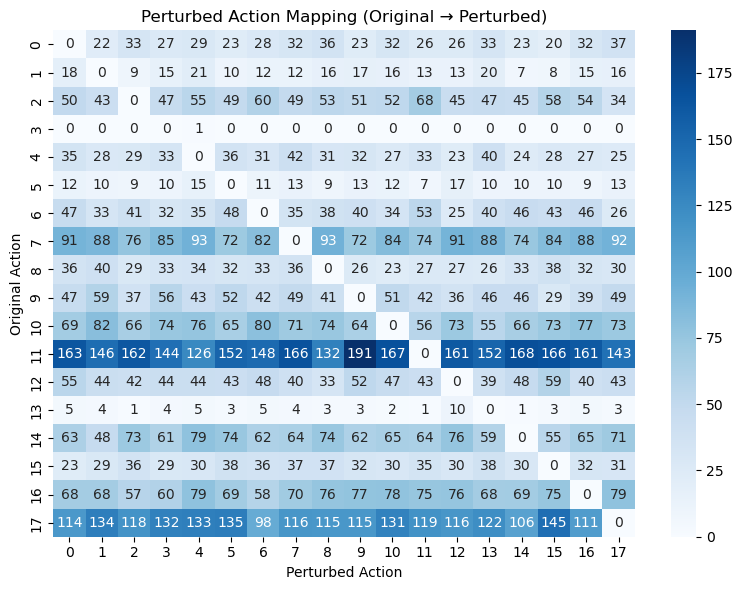

In [3]:
dataset_path = 'datasets/expert_logs/seaquest_expert_perturb10_plotting.pkl'
dataset = load_dataset(dataset_path)

info = inspect_dataset(dataset)
plot_perturbation_heatmap(dataset)
